## Lesson-03

In [1]:
import random

In [2]:
from collections import defaultdict

In [3]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented

In [25]:
class Node:
    def __init__(self, inputs=[], name=None, is_trainable=True):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.is_trainable = is_trainable
        
        for n in self.inputs:
            n.outputs.append(self)
        
        self.value = None
        
        self.gradients = {}
        
    def forward(self):
        raise NotImplementedError
    
    def backward(self):
        raise NotImplementedError
    
    def __repr__(self):
        return "Node: {}".format(self.name)

In [26]:
# Placeholder is same as tensorflow

class Placeholder(Node):
    """
    For x, k, b, weights, bias the value we need to assign value and get the fitted value
    """
    def __init__(self, name, is_trainable=True):
        Node.__init__(self, name=name, is_trainable=is_trainable)
        
    def forward(self, value=None):
        if value is not None: self.value = value
    
    def backward(self):
        self.gradients = {}
        for n in self.outputs:
            self.gradients[self] = n.gradients[self] * 1

class Linear(Node):
    def __init__(self, x=None, weigth=None, bias=None, name=None, is_trainable=False):
        Node.__init__(self, [x, weigth, bias], name=name, is_trainable=is_trainable)
        
    def forward(self):
        k, x, b = self.inputs[1], self.inputs[0], self.inputs[2]
        self.value = k.value * x.value + b.value
        
    def backward(self):
        k, x, b = self.inputs[1], self.inputs[0], self.inputs[2]
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[k] = grad_cost * x.value
            
            self.gradients[x] = grad_cost * k.value
            
            self.gradients[b] = grad_cost * 1
    
        
class Sigmoid(Node):
    def __init__(self, x, name=None, is_trainable=False):
        Node.__init__(self, [x], name=name, is_trainable=is_trainable)
        self.x = self.inputs[0]
        
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x.value)
        
    def partial(self):
        return self._sigmoid(self.x.value) * (1 - self._sigmoid(self.x.value))
    
    def backward(self):
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x] = grad_cost * self.partial() 
    #    print(self.gradients)
    
    
class Relu(Node):
    def __init__(self, x, name=None, is_trainable=False):
        Node.__init__(self, [x], name=name, is_trainable=is_trainable)
        self.x = x
        
    def forward(self):
        self.value = self.x.value * (self.x.value > 0)
        
    def backward(self):
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x] = grad_cost * (self.x.value > 0) 
        

class L2_LOSS(Node):
    def __init__(self, y, y_hat, name=None, is_trainable=False):
        Node.__init__(self, [y, y_hat], name=name, is_trainable=is_trainable)
        self.y = y
        self.y_hat = y_hat
        
    def forward(self):        
        y_v = np.array(self.y.value)
        yhat_v = np.array(self.y_hat.value)
        self.value = np.mean((y_v - yhat_v) ** 2)
        
    def backward(self):
        # 1/n sum (y- yhat)**2
        y_v = np.array(self.y.value)
        yhat_v = np.array(self.y_hat.value)
        self.gradients[self.y] = 2 * np.mean((y_v - yhat_v))
        self.gradients[self.y_hat] = -2 * np.mean((y_v - yhat_v))
     #   print(self.gradients)

In [6]:
def toplogic(graph):
    sorted_node = []
    
    while len(graph) > 0: 

        all_inputs = []
        all_outputs = []
        
        for n in graph:
            all_inputs += graph[n]
            all_outputs.append(n)
        
        all_inputs = set(all_inputs)
        all_outputs = set(all_outputs)
    
        need_remove = all_outputs - all_inputs  # which in all_inputs but not in all_outputs
    
        if len(need_remove) > 0: 
            node = random.choice(list(need_remove))
            
            visited_next = [node]
            if len(graph) == 1:  visited_next += graph[node]
                
            graph.pop(node)
            sorted_node += visited_next

            for _, links in graph.items():
                if node in links: links.remove(node)
        else:
            break
        
    return sorted_node

In [7]:
def topological_sort_feed_dict(feed_dict):
    graph = convert_feed_dict_to_graph(feed_dict)
    
    return toplogic(graph)

In [8]:
def convert_feed_dict_to_graph(feed_dict):
    computing_graph = defaultdict(list)
    
    nodes = [n for n in feed_dict]
    
    while nodes:
        n = nodes.pop(0) 
        
        if isinstance(n, Placeholder):
            n.value = feed_dict[n]
        
        if n in computing_graph: continue

        for m in n.outputs:
            computing_graph[n].append(m)
            nodes.append(m)
    
    return computing_graph

In [9]:
def forward(graph_order, monitor=False):
    for node in graph_order:
        if monitor: print('forward compuiting -- {}'.format(node))
        node.forward()
        
def backward(graph_order, monitor=False):
    for node in graph_order[::-1]:
        if monitor: print('backward computing -- {}'.format(node))
        node.backward()

In [10]:
def run_one_epoch(graph_order, monitor=False):
    forward(graph_order, monitor)
    backward(graph_order, monitor)

In [11]:
def optimize(graph, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in graph:
        if t.is_trainable:
            t.value += -1 * learning_rate * t.gradients[t]

In [12]:
from sklearn.datasets import load_boston

In [13]:
from tqdm import tqdm_notebook

In [14]:
data = load_boston()
X_, y_ = data['data'], data['target']
X_rm = X_[:, 5]

w1_, b1_ = np.random.normal(), np.random.normal()
w2_, b2_ = np.random.normal(), np.random.normal()
w3_, b3_ = np.random.normal(), np.random.normal()


X, y = Placeholder(name='X', is_trainable=False), Placeholder(name='y', is_trainable=False)
w1, b1 = Placeholder(name='w1'), Placeholder(name='b1')
w2, b2 = Placeholder(name='w2'), Placeholder(name='b2')

# build model
output1 = Linear(X, w1, b1, name='linear-01')
output2 = Sigmoid(output1, name='activation')
#output2 = Relu(output1, name='activation')
y_hat = Linear(output2, w2, b2, name='y_hat')
cost = L2_LOSS(y, y_hat, name='cost')

feed_dict = {
    X: X_rm,
    y: y_,
    w1: w1_,
    w2: w2_,
    b1: b1_,
    b2: b2_,
}

graph_sort = topological_sort_feed_dict(feed_dict)

epoch = 1000

batch_num = len(X_rm)

learning_rate = 1e-3

losses = []

for e in tqdm_notebook(range(epoch)):
    loss = 0
    
    for b in range(batch_num):
        index = np.random.choice(range(len(X_rm)))
        X.value = X_rm[index]
        y.value = y_[index]
    
        run_one_epoch(graph_sort, monitor=False)
    
        optimize(graph_sort, learning_rate)
        
        loss += cost.value

    losses.append(loss / batch_num)

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [33]:
graph_sort

[b1, b2, y, w2, w1, X, linear-01, activation, y_hat, cost]

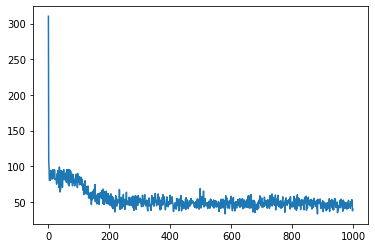

In [16]:
from matplotlib import pyplot as plt

plt.plot(losses)

In [17]:
def predicate(x, graph):
    X.value = x
    forward(graph)
    return y_hat.value

In [18]:
import matplotlib.pyplot as plt

In [19]:
predicate(7, graph_sort)

21.43200909755811

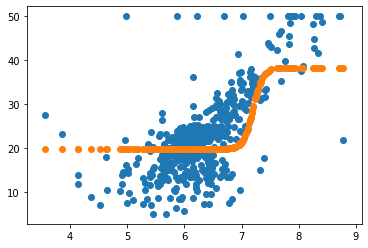

In [20]:
plt.scatter(X_rm, y_)
plt.scatter(X_rm, [predicate(x, graph_sort) for x in X_rm])

## 多维向量版本

In [21]:
import numpy as np
import random

class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Placeholder(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def toplogic(graph):
    sorted_node = []
    
    while len(graph) > 0: 

        all_inputs = []
        all_outputs = []
        
        for n in graph:
            all_inputs += graph[n]
            all_outputs.append(n)
        
        all_inputs = set(all_inputs)
        all_outputs = set(all_outputs)
    
        need_remove = all_outputs - all_inputs  # which in all_inputs but not in all_outputs
    
        if len(need_remove) > 0: 
            node = random.choice(list(need_remove))

            need_to_visited = [node]

            if len(graph) == 1: need_to_visited += graph[node]
                
            graph.pop(node)
            sorted_node += need_to_visited
        
            for _, links in graph.items():
                if node in links: links.remove(node)
        else: # have cycle
            break
        
    return sorted_node

from collections import defaultdict


def convert_feed_dict_to_graph(feed_dict):
    computing_graph = defaultdict(list)
    
    nodes = [n for n in feed_dict]
    
    while nodes:
        n = nodes.pop(0) 
        
        if isinstance(n, Placeholder):
            n.value = feed_dict[n]
        
        if n in computing_graph: continue

        for m in n.outputs:
            computing_graph[n].append(m)
            nodes.append(m)
    
    return computing_graph

def topological_sort_feed_dict(feed_dict):
    graph = convert_feed_dict_to_graph(feed_dict)
    
    return toplogic(graph)


def optimize(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [22]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Placeholder(), Placeholder()
W1, b1 = Placeholder(), Placeholder()
W2, b2 = Placeholder(), Placeholder()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort_feed_dict(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

Total number of examples = 506


In [27]:
losses = []

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        optimize(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss/steps_per_epoch)

Epoch: 1, Loss: 161.970
Epoch: 101, Loss: 5.455
Epoch: 201, Loss: 4.936
Epoch: 301, Loss: 4.343
Epoch: 401, Loss: 4.682
Epoch: 501, Loss: 4.945
Epoch: 601, Loss: 3.676
Epoch: 701, Loss: 4.468
Epoch: 801, Loss: 3.792
Epoch: 901, Loss: 3.802
Epoch: 1001, Loss: 3.551
Epoch: 1101, Loss: 3.336
Epoch: 1201, Loss: 3.592
Epoch: 1301, Loss: 3.652
Epoch: 1401, Loss: 3.346
Epoch: 1501, Loss: 3.479
Epoch: 1601, Loss: 2.996
Epoch: 1701, Loss: 3.741
Epoch: 1801, Loss: 3.230
Epoch: 1901, Loss: 3.462
Epoch: 2001, Loss: 3.337
Epoch: 2101, Loss: 3.093
Epoch: 2201, Loss: 3.296
Epoch: 2301, Loss: 3.570
Epoch: 2401, Loss: 3.253
Epoch: 2501, Loss: 3.350
Epoch: 2601, Loss: 3.751
Epoch: 2701, Loss: 3.022
Epoch: 2801, Loss: 2.982
Epoch: 2901, Loss: 3.225
Epoch: 3001, Loss: 3.414
Epoch: 3101, Loss: 3.542
Epoch: 3201, Loss: 3.427
Epoch: 3301, Loss: 3.179
Epoch: 3401, Loss: 3.394
Epoch: 3501, Loss: 3.281
Epoch: 3601, Loss: 3.268
Epoch: 3701, Loss: 2.950
Epoch: 3801, Loss: 2.976
Epoch: 3901, Loss: 3.339
Epoch: 400

## 2-Dimensions Version

In [28]:
import pandas as pd

In [29]:
dataframe = pd.DataFrame(data['data'])
dataframe.columns = data['feature_names']

In [30]:
dataframe

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [31]:
training_data = dataframe[['RM', 'LSTAT']]

In [32]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = training_data
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Placeholder(), Placeholder()
W1, b1 = Placeholder(), Placeholder()
W2, b2 = Placeholder(), Placeholder()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 200
# Total number of examples
m = X_.shape[0]
batch_size = 1
steps_per_epoch = m // batch_size

graph = topological_sort_feed_dict(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

TypeError: __init__() missing 1 required positional argument: 'name'

In [ ]:
losses = []

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
    
        forward_and_backward(graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        optimize(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss/steps_per_epoch)

In [ ]:
X.value = np.array([[6, 8]])
forward_and_backward(graph)
graph[-2].value[0][0]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [ ]:
fig = plt.figure()

In [ ]:
ax = fig.gca(projection='3d')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = X_.values[:, 0]
Y = X_.values[:, 1]
Z = y_

# Plot the surface.
rm_and_lstp_price = ax.scatter(X, Y, Z)
ax.set_xlabel('RM')
ax.set_ylabel('% of lower state')
ax.set_zlabel('Price')

In [ ]:
training_data.values

In [ ]:
predicate_result = []
for rm, ls in training_data.values:
    X.value = np.array([[rm, ls]])
    forward_and_backward(graph)
    predicate_result.append(graph[-2].value[0][0])

In [ ]:
predicate_result = np.array(predicate_result)

In [ ]:
%matplotlib notebook

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = X_.values[:, 0]
Y = X_.values[:, 1]
Z = predicate_result

# Plot the surface.
rm_and_lstp_price = ax.plot_trisurf(X, Y, Z, color='yellow')

ax.set_xlabel('RM')
ax.set_ylabel('% of lower state')
ax.set_zlabel('Predicated-Price')